In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os


In [2]:
# Simplified U-Net model for demonstration purposes
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        
        self.enc1 = CBR(1, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        
        self.pool = nn.MaxPool2d(2)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = CBR(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = CBR(128, 64)
        
        self.out_conv = nn.Conv2d(64, 1, kernel_size=1)
        
    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        
        dec2 = self.dec2(torch.cat([self.upconv2(enc3), enc2], dim=1))
        dec1 = self.dec1(torch.cat([self.upconv1(dec2), enc1], dim=1))
        
        out = self.out_conv(dec1)
        return torch.sigmoid(out)

In [3]:
# MRI scan processing class
class BrainMRIDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
    
        self.image_filenames = os.listdir(images_dir)
        self.mask_filenames = os.listdir(masks_dir)

        self.image_filenames.sort()
        self.mask_filenames.sort()

    def __len__(self):
        return len(self.images_dir)
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_filenames[idx])
        
        # Load the image and mask
        image = Image.open(image_path).convert("L")  # Convert to grayscale
        mask = Image.open(mask_path).convert("L")    # Convert to grayscale
        
        # Apply transformations (e.g., resize, normalization)
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

In [4]:
# Brain MRI images with tumours
image_path = r'Data\images'
mask_path = r'Data\masks'

# Create dataset and dataloader
dataset = BrainMRIDataset(image_path, mask_path, transform=ToTensor())
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Initialize the model, loss function, and optimizer
model = UNet()
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
# Training loop
for epoch in range(10):  # For demonstration, a few epochs
    for images, masks in dataloader:
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch+1}/{10}, Loss: {loss.item():.4f}')

Epoch 1/10, Loss: 0.4109
Epoch 2/10, Loss: 0.2992
Epoch 3/10, Loss: 0.2409
Epoch 4/10, Loss: 0.2193
Epoch 5/10, Loss: 0.1582
Epoch 6/10, Loss: 0.1402
Epoch 7/10, Loss: 0.1120
Epoch 8/10, Loss: 0.1192
Epoch 9/10, Loss: 0.0845
Epoch 10/10, Loss: 0.0916


In [6]:
# Verification images
verify_path = r'Data\verify'

# Verification images processing class
class VerificationDataset(Dataset):
    def __init__(self, images_dir, transform=None):
        self.images_dir = images_dir
        self.transform = transform

        self.image_filenames = os.listdir(images_dir)
        self.image_filenames.sort()

    def __len__(self):
        return len(self.images_dir)
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.image_filenames[idx])
        image = Image.open(image_path).convert("L")  # Convert to grayscale

        if self.transform:
            image = self.transform(image)

        return image
    
verify_dataset = VerificationDataset(verify_path, transform=ToTensor())
verify_dataloader = DataLoader(verify_dataset, batch_size=1, shuffle=True)

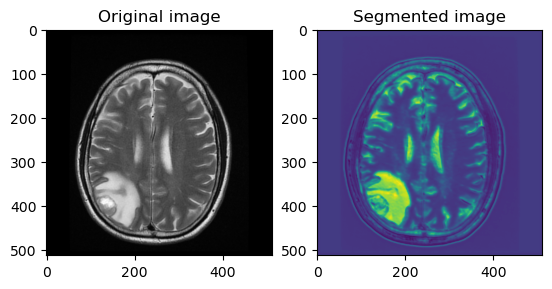

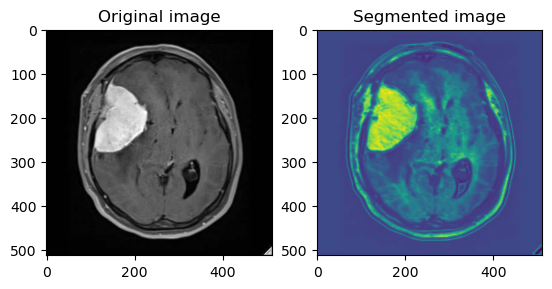

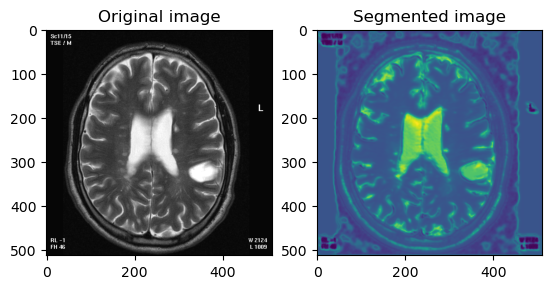

In [18]:
with torch.no_grad():
    for i in range(1,4):
        img = verify_dataset[i]
        pred = model(img.unsqueeze(0))

        plt.figure()
        plt.subplot(1,2,1)
        plt.title('Original image')
        plt.imshow(img.squeeze(), cmap='grey')

        plt.subplot(1,2,2)
        plt.title('Segmented image')
        plt.imshow(pred.squeeze())
        plt.show()


In [17]:
# Example inference (using the same data for simplicity)
model.eval()
with torch.no_grad():
    #for i in range(5):  # Visualizing a few samples
        img, mask = dataset[i]
        pred = model(img.unsqueeze(0))
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Input Image")
        plt.imshow(img.squeeze(), cmap='gray')
        plt.subplot(1, 3, 2)
        plt.title("Ground Truth Mask")
        plt.imshow(mask.squeeze(), cmap='gray')
        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(pred.squeeze().numpy())
        plt.show()

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 1, 1, 512, 512]